# IMDB

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from the readily available tfdataset by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml
import numpy as np

## Create Datasets

In [3]:
# import tensorflow_datasets as tfds
# dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
#                           as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset = train_dataset.shuffle(10000)
# train_dataset = train_dataset.padded_batch(64)

In [4]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "imdb_reviews/subwords8k",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
        "as_supervised": False,
        "with_info": True,
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed"
    },
}

In [5]:
# create the datasets based on the above defined names/splits/specifed data
# TODO: allow for with_info
ds_dict_raw, info = dd.read(dd_dict)

root dir set to None
as_supervised set to False
with_info set to True
W0810 09:07:40.765556 139900810925888 text_feature.py:61] TFDS datasets with text encoding are deprecated and will be removed in a future version. Instead, you should use the plain text version and tokenize the text using `tensorflow_text` (See: https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example)
W0810 09:07:41.724169 139900810925888 text_feature.py:61] TFDS datasets with text encoding are deprecated and will be removed in a future version. Instead, you should use the plain text version and tokenize the text using `tensorflow_text` (See: https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example)
W0810 09:07:41.808962 139900810925888 text_feature.py:61] TFDS datasets with text encoding are deprecated and will be removed in a future version. Instead, you should use the plain text version and tokenize the text using `tensorflow_text` (See: https://www.tensorflow.org/tutorials/tenso

In [6]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


## alter dataset

In [7]:
def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v


def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v


def new_py_function(func, inp, Tout, name=None):
    # https://github.com/tensorflow/tensorflow/issues/27679
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(
            inp, flat_inp, expand_composites=True
        )
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)

    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(
        func=wrapped_func,
        inp=tf.nest.flatten(inp, expand_composites=True),
        Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
        name=name,
    )
    spec_out = tf.nest.map_structure(
        _dtype_to_tensor_spec, Tout, expand_composites=True
    )
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

In [8]:
def my_text_fn(ddict):
    text = ddict['text']
    label = ddict['label']
    
    label = tf.reshape(label, [1])
    text = tf.keras.preprocessing.sequence.pad_sequences(
        [text.numpy()],
        maxlen=500,
        truncating="pre",
        padding='pre',
        value=0.0,
        dtype='float').squeeze()
    # np.float


    return {"text": text, "label": label}

def output_tuple(ddict):
    return ddict['text'], ddict['label']

In [9]:
new_d = {}
for k, cur_ds in ds_dict_raw.items():
    cur_ds = cur_ds.map(
        lambda data: new_py_function(
            my_text_fn, inp=[data], Tout=({"text": tf.int64, "label": tf.int64})
        )
    )
    cur_ds = cur_ds.map(output_tuple)
    new_d[k] = cur_ds

In [10]:
ds_dict = {"imdb": new_d}

In [11]:
ds_dict

{'imdb': {'train': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>,
  'val': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>,
  'test': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>}}

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## subset

In [12]:
# sample_size = 10000
# for ds_name, cur_dict in ds_dict.items():
#     for split_name, split_ds in cur_dict.items():
#         ds_dict[ds_name][split_name] = split_ds.take(sample_size)

## Specify the Model

In [13]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

config_logger: WARNING  some keys have not been checked for unparsed keys:
 - main_config [model][path] = ./model_config_b.yml

 This is common when the config contains model:path: <some_path>.yml and means that there could be extra keys in this model config that are not being parsed+used by yeahml. in a future release, this could be addressed by building parsing logic in `src/yeahml/config/create_configs.py`


## Build the model

In [14]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


In [15]:
model.summary()

Model: "model_b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional_block (bidir_b (None, None, 128)         66048     
_________________________________________________________________
bidir_2 (bidir_block)        (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
y_pred (Dense)               (None, 1)                 65  

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [16]:
ds_dict

{'imdb': {'train': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>,
  'val': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>,
  'test': <MapDataset shapes: (<unknown>, <unknown>), types: (tf.int64, tf.int64)>}}

In [17]:
%%time
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - imdb train: 1
train_logger: INFO     done validation - 18688
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - imdb train: 2
train_logger: INFO     done validation - 37376
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - imdb train: 3
train_logger: INFO     done validation - 56064
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - imdb train: 4
train_logger: INFO     done validation - 74752
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - imdb train: 5
train_logger: INFO     done validation - 93440
train_logger: INFO     op

CPU times: user 17min 48s, sys: 4min 28s, total: 22min 17s
Wall time: 13min 53s


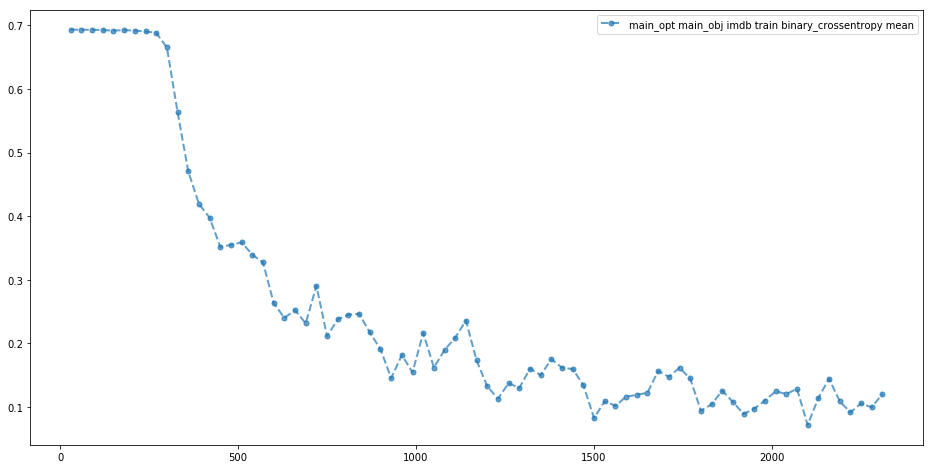

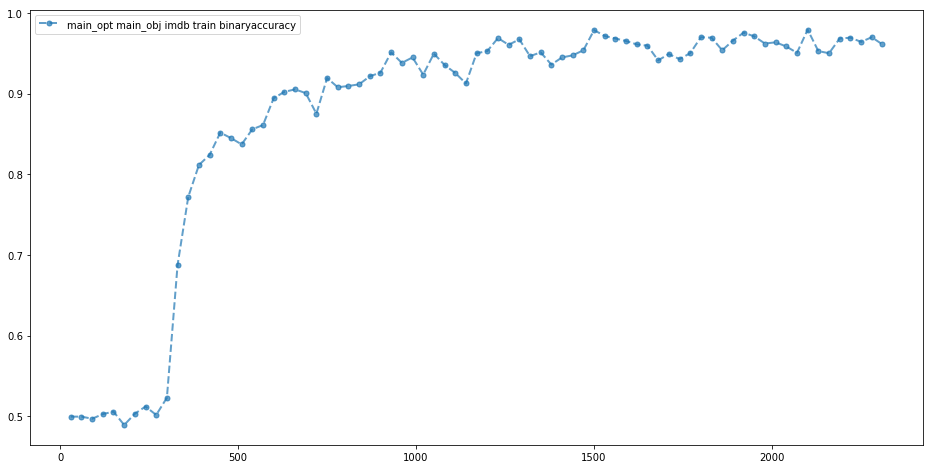

In [18]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=True,
    validation=False,
    loss=True,
    size=(16, 8),
)

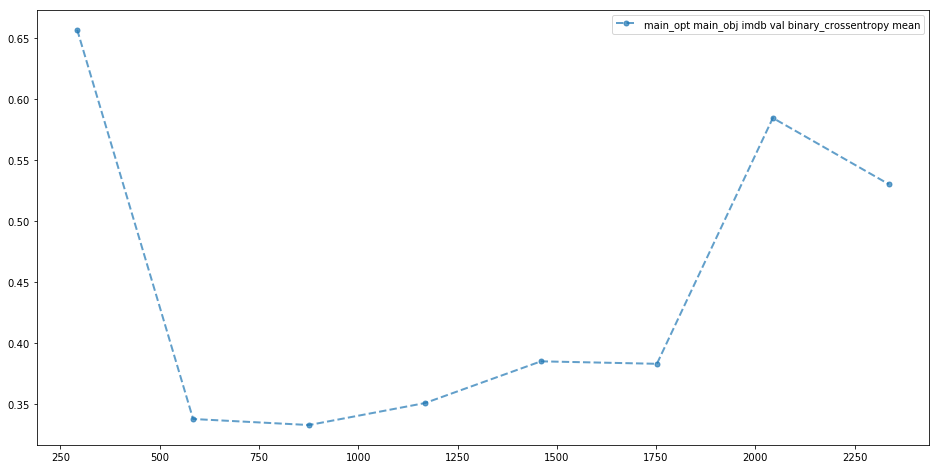

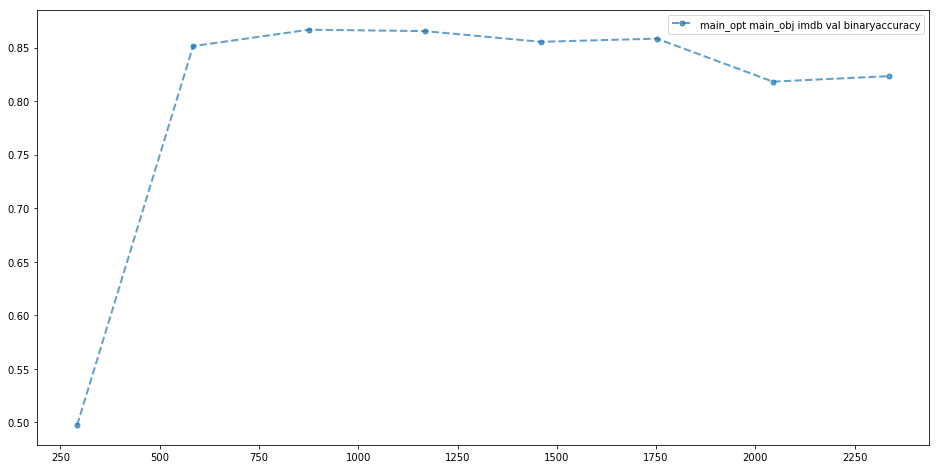

In [19]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=False,
    validation=True,
    loss=True,
    size=(16, 8),
)

## Evaluate the Model

In [21]:
# eval_dict = yml.eval_model(
#     model,
#     yml_dict,
#     dataset=ds_dict["test"]
# )
# print(eval_dict)

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```